<a href="https://colab.research.google.com/github/bolein/simplenet/blob/master/readme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSP 595 - Deep Learning Spring 2019 @ Illinois Institute of Technology 

Vadym Ovcharenko A20406327 vovcharenko@hawk.iit.edu

In this project, I implement a CPU-based deep learning framework using nothing but Numpy. The API for the framework is heavily inspired by Keras, although the implementation is quite different. I test the framework on 3 different datasets: one is syntetically generated, and two popular datasets from UCI Data repositories. Eventually, I compare the results with the Tensorflow-CPU-backed version of the Keras. I conclude with the statement that the framework achieves equivalent to Keras learning performance while being simplier and more transparent for educational purposes. 

## SimpleNet
The following is the implementation of the framework in Python.  The main abstractions are `Model` and `Dense`.  The framework design is highly oriented on fully-connected networks. Nevertheless the abstraction of a `Dense` layer stands alone from the `Model` which may have an arbitrary number of layers.

Other abstracted concepts are `Loss`,  `Activation`,  `Optimizer`. I implemented several activations:  linear, sigmoid and softmax, although the framework is open for other extensions. For optimizers, I implemented an SGD and Adam. The implementation of Adam is a little different from the one in Keras and is purely based on the Wikipedia definition. Finally, there are two loss functions supported: MSE and categorical cross entropy.

The computational part of the framework is inspired by the concept of computational graphs from http://www.deeplearningbook.org/. The computational graph in this architecture consists of the nodes of just one type: Layer, which can be broken down into the two operations: matrix multiplication and activation function. 
```
                                matmul  activation
                            W-->+---+  S  +---+  Z
                                + * +---->+ a +---->
                            X-->+---+     +---+
```
Each node (Layer) knows how to compute it's forward and backward pass for the two operations. For the last layer, the model uses a trick to aviod computing the derrivative of the output of the final activation function with respect to its input by using the simplified form of gradient for the loss function with respect to the input of the activation.  

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras import backend as K
import sklearn

Using TensorFlow backend.


In [0]:
class Activation():
  @staticmethod
  def linear(layer, x, dx = False):
    if dx:
      return np.ones(x.shape)
    else:
      return x
    
  @staticmethod    
  def sigmoid(layer, x, dx = False):
    sigm = 1. / (1. + np.exp(-x))
    if dx:
      return sigm*(1-sigm)
    else:
      return sigm

  @staticmethod    
  def softmax(layer, x, dx = False):
    x -= np.max(x, axis=1).reshape(-1,1)
    exp = np.exp(x)
    sm = exp / np.sum(exp, axis=1).reshape(-1,1)
    
    if dx:
      # Jacobian for softmax is not defined (the network will use an 
      # optimization that makes it possible to compute the gradient of a
      # layer without explicitly computing the intermediate dL/dS
      raise Exception("Don't know host to backpropagate through softmax. \
                      Softmax activation may only be used in the last layer.")
    else:
      return sm

class Loss():
  @staticmethod
  def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))
    
  @staticmethod
  def categorical_crossentropy(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
class SGD():  
  def __init__(self, lr = 1e-3):
    self.lr = lr
    
  def update(self, model, gradients):
    for layer, gradient in zip(model.layers, gradients):
      layer.W -= self.lr * gradient
    
class Adam():  
  def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999):
    self.lr = lr
    self.beta_1 = beta_1
    self.beta_2 = beta_2
    # init momentums
    self.ms = None
    self.vs = None
    self.iteration = 0
    self.epsilon = np.finfo(float).eps
    
  def update(self, model, gradients):
    self.iteration += 1
    
    if self.ms is None:
      shapes = [layer.W.shape for layer in model.layers]
      self.ms = [np.zeros(shape) for shape in shapes]
      self.vs = [np.zeros(shape) for shape in shapes]
    
    for i, layer, g, m, v in zip(range(0, len(gradients)), model.layers, gradients, self.ms, self.vs):
      m = self.beta_1 * m + (1 - self.beta_1) * g
      v = self.beta_2 * v + (1 - self.beta_2) * np.square(g)
      
      m_prime = m / (1 - self.beta_1 ** self.iteration)
      v_prime = v / (1 - self.beta_2 ** self.iteration)
      
      layer.W -= self.lr * m_prime / (np.sqrt(v_prime) + self.epsilon)
      
      self.ms[i] = m
      self.vs[i] = v
    
    
class Dense():
  def __init__(self, num_neurons, num_inputs, activation = 'linear'):
    # Initialize weights randomly
    # The input dimension is + 1 because of bias
    # W is a 2D matrix where each column is a weight vector for a layer
    # TODO: infer dimensions at compile time
    self.W = np.random.rand(num_inputs + 1, num_neurons) / 100.
    
    # Node remembers it's input for gradient computation
    # A layer actually represents two nodes in the computational graph
    # For the matrix multiplication S=X*W, and for activation z = a(S).
    #    
    #         matmul  activation
    #     W-->+---+  S  +---+  Z
    #         + * +---->+ a +---->
    #     X-->+---+     +---+
    #
    # Therefore, this node has to remember two inputs to propagate gradient
    self.X = None
    self.S = None
    
    # Initialize activation function
    self.activation = activation
    if activation == 'linear':
      self.a = Activation.linear
    elif self.activation == 'sigmoid':
      self.a = Activation.sigmoid
    elif self.activation == 'softmax':
      self.a = Activation.softmax
    elif callable(activation):
      self.a = activation
    else:
      raise Exception('Unknown activation {}'.format(activation))
    
  def forward(self, X):
    # Stack ones at the first column of X for bias.
    ones = np.ones((X.shape[0],1))
    X_1 = np.concatenate((ones, X), axis=1)
    # Memorize input of the forward pass.
    self.X = X_1
    # Memorize input to the activation function.
    self.S = self.X.dot(self.W)
    return self.a(self, self.S)
  
  """Push the incoming gradient through the layer.
  Calculates gradients with respect to the input and weights of the layer.
  """
  def backward(self, incoming_gradient, activation = True):
    if activation:
      # Propagate gradient through the activation function.
      incoming_gradient *= self.a(self, self.S, dx = True)
      
    # Compute gradient of the weights.
    dW = np.dot(self.X.T, incoming_gradient)
    # Compute gradient for the input.
    # Drop the bias weights from weights matrix because we cannot propagate 
    # gradient for artificially created input row of ones.
    dX = np.dot(incoming_gradient, self.W[1:].T)
      
    return dX, dW
    
class History():  
  def __init__(self):
    self.train = []
  
  def plot(self):
    plt.plot(self.train)
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
class Model():  
  def __init__(self):
    self.layers = []
    self.loss = None
    self.l = None
    
  def add(self, layer):
    self.layers.append(layer)
  
  """Build the computational graph
  """
  def compile(self, loss):
    self.loss = loss
    if loss == 'mse':
      self.l = Loss.mse
    elif loss == 'categorical_crossentropy':
      self.l = Loss.categorical_crossentropy
    elif callable(loss):
      self.l = loss
    else:
      raise Exception('Unknown loss {}'.format(loss))
  
  def predict(self, X):
    # Check if compiled.
    if self.l is None:
      raise Exception('Not compiled')
      
    return self.forward(X)
  
  def forward(self, X):
    # Propagate the input through the layers.
    z = X
    for layer in self.layers:
      z = layer.forward(z)
    return z
  
  def train(self, X_train, y_train, num_epochs = 1, optimizer = SGD(), batch_size = 32, log = 'verbose'):
    # Check if compiled.
    if self.l is None:
      raise Exception('Not compiled')
    
    sample_size = X_train.shape[0]
    print('Training on {} examples...'.format(sample_size))
    history = History()
    
    for epoch in range(num_epochs):
      # join x and y into a single array
      xy = np.concatenate((X_train, y_train), axis=1)
      # shuffle the train data (we want different mini-batches for each epoch)
      np.random.shuffle(xy)
      # split into mini batches
      num_mini_batches = sample_size // batch_size
      mini_batches = np.array_split(xy, 1 if num_mini_batches == 0 else num_mini_batches)
      
      examples_processed = 0
      
      # update model for each mini batch
      for mini_batch in mini_batches:
        mini_X, mini_y = np.hsplit(mini_batch, [-y_train.shape[1]])
        loss = self.train_batch(mini_X, mini_y, optimizer)
        examples_processed += mini_batch.shape[0]
        if log == 'verbose':
          print('\rEpoch {}/{} [{}/{}] - loss: {}'
                .format(epoch + 1, num_epochs, examples_processed, sample_size, loss), end='') 
 
      epoch_loss = self.l(y_train, self.predict(X_train))
      history.train.append(epoch_loss)
      if log == 'verbose':
        print('\rEpoch {}/{} - loss: {}'.format(epoch + 1, num_epochs, epoch_loss)) 

    return history

             
  def train_batch(self, X, y, optimizer):
    y_pred = self.forward(X)
    # Gradients for each layer.
    gradients = []
    
    # We use an optimization trick for computing gradients for the output layer.
    # We calculate the gradient for both loss and activation of the last layer 
    # instead of differentiating them separately. e.g. we do not need to compute 
    # the 3D Jacobian for softmax derivative.
    dX = y_pred - y
    
    # Backpropagate the error.
    for i, layer in enumerate(reversed(self.layers)):
      dX, dW = layer.backward(dX, activation = i != 0)
      gradients.insert(0, dW)
      
    # Update the parameters.
    optimizer.update(self, gradients)
     
    # Calaculate the total loss after the update.
    loss = self.l(y, y_pred)
    return loss


## Linear regression problem

I can now test the model on a syntethic dataset. I generate a simple linear regression problem to be able to easily visualize the results. It helped with debugging the framework at the early stages of development. I implemented both SGD and Adam optimizers to improve the learning process by calculating gradient decay for each parameter of the network.

Training on 9 examples...
Training on 9 examples...
Training on 9 examples...


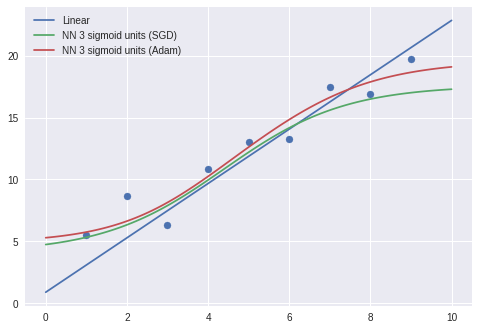

In [0]:
def plot_predictions(x, y_predicted):
  plt.plot(x, y_predicted, linestyle='-')

np.random.seed(443)

# randomized linear function
def f(X, w):
  return np.dot(X,w) + np.random.rand(X.shape[0]) * 5

X = np.array([range(1, 10)]).T
w = [2]
y = f(X, w)

# SimpleNet with no hidden layers (basically a linear model)
np.random.seed(443)
lm = Model()
lm.add(Dense(num_neurons = 1, num_inputs=1, activation='linear'))
lm.compile(loss = 'mse')
lm.train(X, y.reshape(-1, 1), batch_size=9, num_epochs=100, log=None, optimizer=SGD(lr=0.001))
  
# SimpleNet with one hidden layer with 3 neurons SGD optimizer
np.random.seed(443)
model = Model()
model.add(Dense(num_neurons = 3, num_inputs=1, activation='sigmoid'))
model.add(Dense(num_neurons = 1, num_inputs=3, activation='linear'))
model.compile(loss = 'mse')
model.train(X, y.reshape(-1, 1), batch_size=9, num_epochs=100, log='None', optimizer=SGD(lr=1e-2))

# SimpleNet with one hidden layer with 3 neurons Adam optimizer
np.random.seed(443)
adamModel = Model()
adamModel.add(Dense(num_neurons = 3, num_inputs=1, activation='sigmoid'))
adamModel.add(Dense(num_neurons = 1, num_inputs=3, activation='linear'))
adamModel.compile(loss = 'mse')
adamModel.train(X, y.reshape(-1, 1), batch_size=9, num_epochs=100, log=None, optimizer=Adam(lr=0.2))

# Train with SGD for 100 epochs
plt.scatter(X, y) # plot data
X_test = np.linspace(0, 10, 100).reshape(-1,1)
plot_predictions(X_test, lm.predict(X_test))
plot_predictions(X_test, model.predict(X_test))
plot_predictions(X_test, adamModel.predict(X_test))
plt.legend(['Linear', 'NN 3 sigmoid units (SGD)', 'NN 3 sigmoid units (Adam)'], loc='upper left')

The model is able to fit this simple problem after 100 epochs. It is clear that NN converges slowly and overfits the training data. Clearly, it takes less time for the model to converge with Adam optimizer and the fit seems to be better (although showing clear signs of overfitting).

## Iris Dataset

I evaluate the framework using Iris Dataset. Additionally, I compare the model fit to the equivalent classifier built with Keras. This helped to investigate the errors and debug the framework.

In [0]:
def plot_keras_history(history):
  plt.plot(history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')

Training on 105 examples...
0.9777530589543938 0.9777530589543938


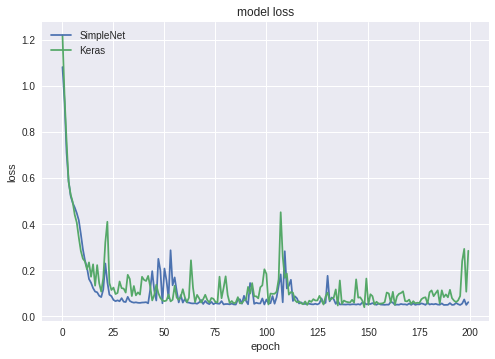

In [0]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, keras.utils.to_categorical(iris.target), test_size=0.3, stratify=keras.utils.to_categorical(iris.target))

# SimpleNet
np.random.seed(448)
model = Model()
model.add(Dense(num_neurons = 3, num_inputs=4, activation='sigmoid'))
model.add(Dense(num_neurons = 3, num_inputs=3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy')
history = model.train(X_train, y_train, optimizer=Adam(lr=0.2), log=None, num_epochs=200)
history.plot()

# Keras
np.random.seed(448)
kerasModel = keras.models.Sequential()
kerasModel.add(keras.layers.Dense(3, input_shape=(4,), activation='sigmoid') )
kerasModel.add(keras.layers.Dense(3, activation='softmax'))
kerasModel.compile(keras.optimizers.Adam(lr=0.2),'categorical_crossentropy')
kerasHistory = kerasModel.fit(X_train, y_train, epochs=200, verbose=0)

f1_simple = sklearn.metrics.f1_score(y_test, model.predict(X_test) > 0.5, average='weighted')
f1_keras = sklearn.metrics.f1_score(y_test, kerasModel.predict(X_test) > 0.5, average='weighted')
print(f1_simple, f1_keras)

plot_keras_history(kerasHistory)
plt.legend(['SimpleNet', 'Keras'], loc='upper left')

The model shows almost equivalent results to the Keras classifier. The learning curve is almost identical. Both models achieve over .97 weighted f-score on the test set in 200 epochs.

## MNIST Fashion dataset

I also test the framework on the MNIST fashion dataset, which contains 60,000 greyscale article images. I simplify the problem by only classifying in 3 classes instead of 10. Once again, I compare the training performance with a Keras network. 

In [0]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = train_images / 255.0
test_images = test_images / 255.0

train_index = np.argwhere(np.isin(train_labels, [0, 1, 2]))
test_index = np.argwhere(np.isin(test_labels, [0, 1, 2]))

train_images = np.take(train_images, train_index, axis=0).reshape(-1, 28, 28)
train_labels = np.take(train_labels, train_index).reshape(-1)
test_images = np.take(test_images, test_index, axis=0).reshape(-1, 28, 28)
test_labels = np.take(test_labels, test_index).reshape(-1)

X_train = train_images.reshape(-1, 784)
y_train = keras.utils.to_categorical(train_labels)
X_test = test_images.reshape(-1, 784)
y_test = keras.utils.to_categorical(test_labels)

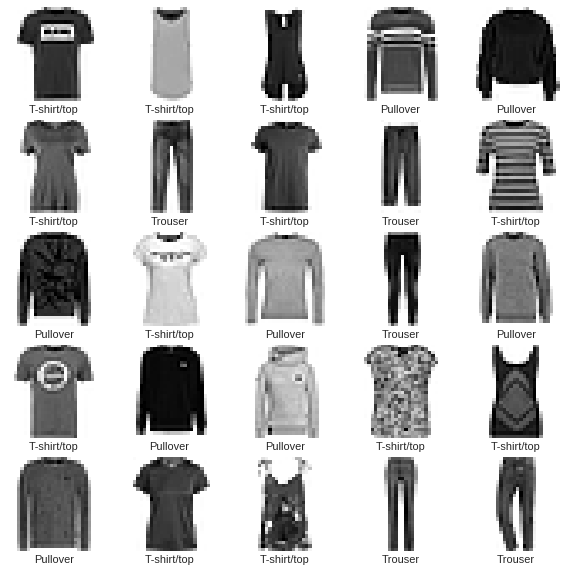

In [0]:
# plot the data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

For this problem I use a network with single hidden layer that has 128 units and sigmoid activation. The architecture is taken from TensorFlow tutorial.

In [0]:
# SimpleNet
np.random.seed(448)
model = Model()
model.add(Dense(num_neurons = 128, num_inputs=784, activation='sigmoid'))
model.add(Dense(num_neurons = 3, num_inputs=128, activation='softmax'))
model.compile(loss = 'categorical_crossentropy')
history = model.train(X_train, y_train, optimizer=Adam(lr=0.005), batch_size=128 ,log='verbose', num_epochs=100)

# Keras
np.random.seed(448)
kerasModel = keras.models.Sequential()
kerasModel.add(keras.layers.Dense(128, input_shape=(784,), activation='sigmoid') )
kerasModel.add(keras.layers.Dense(3, activation='softmax'))
kerasModel.compile(keras.optimizers.Adam(lr=0.005),'categorical_crossentropy')
kerasHistory = kerasModel.fit(X_train, y_train, epochs=100, batch_size=128)

0.9721815924810092 0.9705424199955284


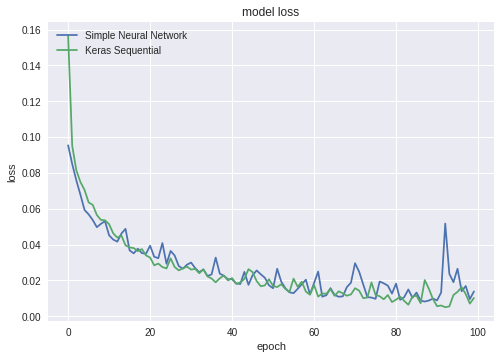

In [0]:
f1_simple = sklearn.metrics.f1_score(y_test, model.predict(X_test) > 0.5, average='weighted')
f1_keras = sklearn.metrics.f1_score(y_test, kerasModel.predict(X_test) > 0.5, average='weighted')
print(f1_simple, f1_keras)
history.plot()
plot_keras_history(kerasHistory)
plt.legend(['Simple Neural Network', 'Keras Sequential'], loc='upper left')

Once again, I achieve equivalent to Keras results. Suprisingly, both models are able to converge to over .97 f-score on the test set in 100 epochs on this quite challengling problem. 

### Visualize predictions

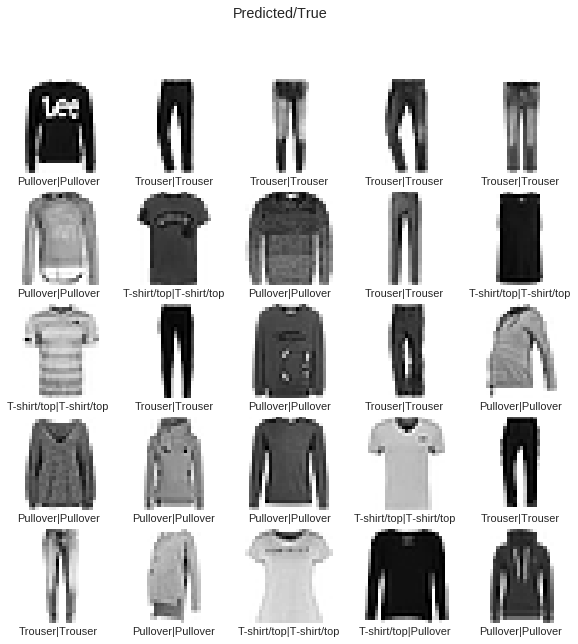

In [0]:
predictions = np.argmax(model.predict(X_test), axis=1)
fig = plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel('{}|{}'.format(class_names[predictions[i]], class_names[test_labels[i]]))
fig.suptitle('Predicted/True')
plt.show()

Clearly, the model is able to do very accurate predictions about the unseen data.

## Conclusions and future work
I achieved a learning performance comparable to the CPU version of the Keras library, while being able to control the behavior of the network in python memory. It was a great challenge to implement this project which gave me a great learning experience. I implemented the framework from scratch, only consulting the book. I had no insight into the implementation of Keras. I only used the API as the baseline, without actually looking into the source code (except for the Adam optimizer). I learned a lot about Python, Numpy and Neural Networks overall. Consequently, I plan to extend the framework with other Layers/Activations/Optimizers.